CLASSIFICATION OF TIME SERIES DATA USING PyTorch only 
1. create and train neural net to classify timeseries data
2. use transfer learning to classify time series data

Import helper notebook and libraries

In [1]:
from ipynb.fs.full.helper import *

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from   torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict

DATA PREPARATION

In [6]:
# load train and test data
test_path = "GunPoint/GunPoint_TEST.txt"
train_path = "GunPoint/GunPoint_TRAIN.txt"
# to pandas dataframe
df1 = txt_to_pd(test_path)
df2 = txt_to_pd(train_path)
# join test and train data
df = pd.concat([df1, df2], ignore_index=True)
df.shape

(200, 151)

In [7]:
# get labels from data
labels = df[0]
df.drop(columns=[0], inplace=True)
df.shape, labels.shape

((200, 150), (200,))

Encript TimesSeries using GramianAngularField, MarkovTransitionField, RecurrencePlot
https://pyts.readthedocs.io/en/stable/generated/pyts.image.GramianAngularField.html

In [8]:
#Each encriprion returns 200 matrix of 150*150 
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot

X = df.to_numpy() 

gadf = GramianAngularField(method='difference')
X_gadf = gadf.fit_transform(X)

gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(X)

mtf = MarkovTransitionField(n_bins=8)
X_mar = mtf.fit_transform(X)

rp = RecurrencePlot(threshold='point', percentage=20)
X_rp = rp.fit_transform(X)

print(X_gadf.dtype)
X_gadf.shape, X_gasf.shape, X_mar.shape, X_rp.shape

float64


((200, 150, 150), (200, 150, 150), (200, 150, 150), (200, 150, 150))

dtype('float64') default for np, torch defdault float32 
to avoid RuntimeError: mat1 and mat2 must have the same dtype when train network 
cast np.float32(item) 

In [9]:
# data to torch tensor 
images_list = [X_gadf, X_gasf, X_mar, X_rp] 
data = torch.cat([torch.from_numpy(np.float32(item)) for item in images_list], dim=0)
#and labels 
a = labels.to_list() 
# Note:
# NLLLost expect class indices as target vector 
# our classes are 1 and 2 and output tensor shape[20,2] -> IndexError: Target 2 is out of bounds.

# Convert classes to indices 
labels = list()
for x in a:
    if x == 1.0:
        labels.append(0)
    else: labels.append(1)

y = labels + labels + labels + labels # targets to match data
labels = torch.tensor(y).unsqueeze(dim=1)

print(data.shape , labels.shape)
data.dtype

torch.Size([800, 150, 150]) torch.Size([800, 1])


torch.float32

Prepare Data Loaders

In [10]:
#Split data into training vlidation and testing set 
# As I have small data set Ill use 70% for training and 15% for validation 
#and save 15% as unseen data for testing network
data_set = list(zip(data, labels))
valid_size, batch_size = 0.15, 20

# get indices for Sampler
len_data_set = len(data_set)
idx = list(range(len_data_set))# list of indices 
np.random.shuffle(idx)
split = int(np.floor(len_data_set*valid_size))*2 # *2 (for validation and testing data loaders)
train_idx = idx[split:] # train_data indices
idx = idx[:split] # update indices list
np.random.shuffle(idx)# reshuffle
valid_idx = idx[:120]
test_idx = idx[120:]

#check data splits
print(['Train', 'Valid', 'Test']) 
print(list(map(len,[train_idx, valid_idx, test_idx])))

#Define Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler  = SubsetRandomSampler(test_idx)

#Data Loaders
train_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, sampler=valid_sampler)
test_loader  = torch.utils.data.DataLoader(data_set, batch_size=batch_size, sampler=test_sampler )

['Train', 'Valid', 'Test']
[560, 120, 120]


Print batch with labels

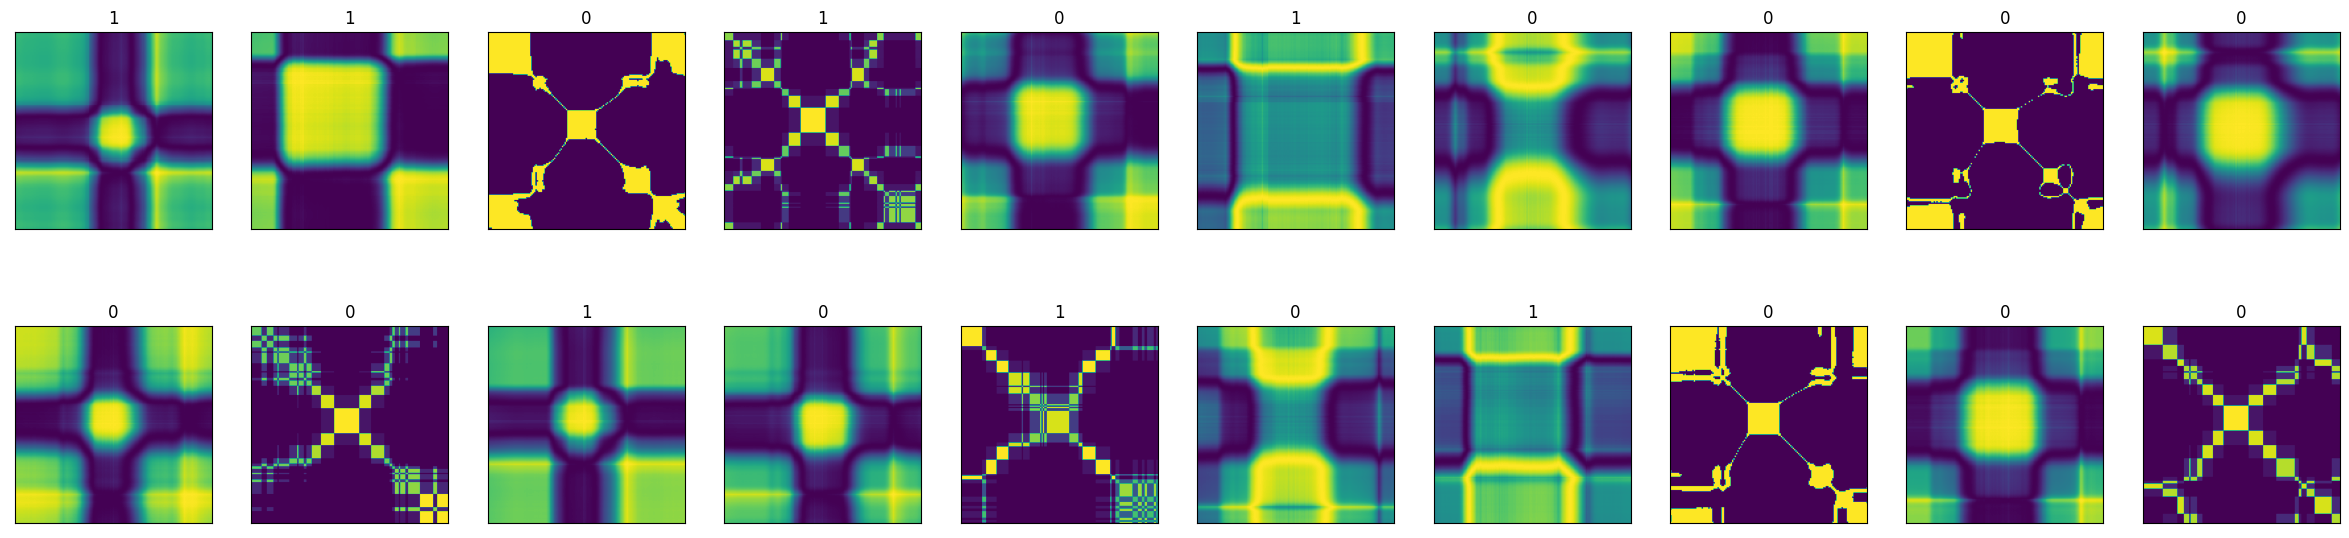

In [7]:
images, labels = next(iter(train_loader))
# plot the image of timesSeries in the batch, along with the corresponding labels
fig = plt.figure(figsize=(30, 7))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]))
    # print label for each image
    ax.set_title(str(labels[idx].item()))

Two approaches from here:
1. create simple neural net classifier train it and chech accuracy 
2. Use ResNet pre trained arhitecture ( transfer learning) fine tune it for mine data

Approach no 1: 
helper notebook conatins: 
class Net( neural net definition )
train , test and print_test_data functions

In [8]:
model = Net(22500, 2, [10000, 500])
criterion = nn.NLLLoss() #cross entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.01)
model

Net(
  (layers): ModuleList(
    (0): Linear(in_features=22500, out_features=10000, bias=True)
    (1): Linear(in_features=10000, out_features=500, bias=True)
  )
  (output): Linear(in_features=500, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [9]:
#train model see helper notebook
#train(model, optimizer,criterion, train_loader,valid_loader, epochs=20)
#load last saved good configuration after training
model.load_state_dict(torch.load('model.pt'))


<All keys matched successfully>

In [10]:
classes = ['Gun', 'No_Gun']
#evaluate model on unseen test data
_,_,class_correct, class_total = test(model,test_loader,criterion, classes )
#print eval data
print_test_data(class_correct, class_total, classes)
        

Test Loss: 0.2361	
Test Accuracy (Overall): 0.9083
Test Accuracy of   Gun: 100% (67/67)
Test Accuracy of No_Gun: 79% (42/53)


2nd Approach:
 Use ResNet pretrained arhitecture ( transfer learning) fine tune it 

In [4]:
# load pretrained model
resnet18 = models.resnet18(pretrained=True)

#freeze model paramiters
for param in resnet18.parameters():
    param.requires_grad = False

#define new head of model
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(512,256)),
                                        ('Relu', nn.ReLU()),
                                        ('dropout', nn.Dropout(p=0.2)),
                                        ('fc2', nn.Linear(256,2)),
                                        ('output', nn.LogSoftmax(dim=1))]))
#replace last layer of resnet18 with classifier
resnet18.fc=classifier
criterion = nn.NLLLoss() #cross entropy loss
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)

In [12]:
#_,_ = train(resnet18, optimizer, criterion, train_loader, valid_loader)

In [11]:
classes = ['Gun', 'No_Gun']
resnet18.load_state_dict(torch.load('model1.pt'))
_,_,class_correct, class_total = test(resnet18,test_loader,criterion, classes)
print_test_data(class_correct, class_total, classes)

Test Loss: 0.0683	
Test Accuracy (Overall): 0.9750
Test Accuracy of   Gun: 100% (69/69)
Test Accuracy of No_Gun: 94% (48/51)
